In [ ]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import optimizers
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import plot_model

from IPython.display import clear_output

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

## Set up Trajectories
define functions to help create trajectories to given Lorenz equation using random initial conditions

In [4]:
sigma=10; beta=8/3; rho=28; 
def lrz_rhs(t,x):
    return [sigma*(x[1]-x[0]), x[0]*(rho-x[2]), x[0]*x[1]-beta*x[2]];

In [5]:
end_time = 8
sample_rate = 100
t = np.linspace(0,end_time,sample_rate*end_time,endpoint=True)
def lrz_trajectory():
    x0 = 20*(np.random.rand(3)-.5)
    sol = integrate.solve_ivp(lrz_rhs,[0,end_time],x0,t_eval=t,rtol=1e-10,atol=1e-11)
    return sol.y

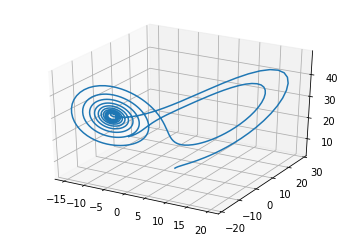

In [6]:
x = lrz_trajectory()
plt.figure()
plt.gca(projection='3d')
plt.plot(x[0],x[1],x[2])
plt.show()

## Generate Data
`Y` is composed of position vectors one step forward in time from those in `X`. Data comes from `N` trajectories each with `traj_length` entries

In [9]:
from scipy.io import loadmat
xy = loadmat('xy.mat')
X = xy['input']
Y = xy['output']

In [ ]:
N = 200
D = np.zeros((N,3,len(t)))
for i in range(N):
    progress_bar((i+1)/N)
    D[i] = lrz_trajectory()
#np.savez('trajectories',D=D)

In [ ]:
#D = np.load('trajectories.npz')['D']

In [ ]:
X = np.transpose(D[:,:,:-1],axes=[0,2,1]).reshape(-1,3)
Y = np.transpose(D[:,:,1:],axes=[0,2,1]).reshape(-1,3)

In [ ]:
i=231
X[i]==Y[i-1]

In [ ]:
np.shape(X)

In [47]:
num_epochs = 500
input_shape = (X.shape[1],)

inputs = Input(shape = input_shape)

x = Dense(output_dim = 100, activation = 'sigmoid')(inputs)
#x = Dense(output_dim = 512, activation = 'selu')(inputs)
x = Dense(output_dim = 200, activation = 'sigmoid')(x)
#x = Dense(output_dim = 500, activation = 'elu')(x)
x = Dense(output_dim = 3, activation = 'linear')(x)

output = x

model = Model(input=inputs,output=output)
lr = 0.01
#decay = lr/num_epochs-1e-9 #optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(lr=lr)#optimizers.rmsprop(lr=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error') #compiling here

epoch = num_epochs
 
model.fit(X, Y,  batch_size=4200, epochs=num_epochs, validation_split=0.05, callbacks=[], verbose=1)
         


/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=100, activation="sigmoid")`
/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=200, activation="sigmoid")`
/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, activation="linear")`
/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 76000 samples, validate on 4000 samples
Epoch 1/500
76000/76000 [==============================] - 0s 6us/step - loss: 124.4811 - val_loss: 34.3067
Epoch 2/500
76000/76000 [==============================] - 0s 1us/step - loss: 31.9122 - val_loss: 15.8710
Epoch 3/500
76000/76000 [==============================] - 0s 1us/step - loss: 24.9509 - val_loss: 14.3260
Epoch 4/500
76000/76000 [==============================] - 0s 1us/step - loss: 22.1246 - val_loss: 11.9713
Epoch 5/500
76000/76000 [==============================] - 0s 1us/step - loss: 16.2800 - val_loss: 7.7879
Epoch 6/500
76000/76000 [==============================] - 0s 1us/step - loss: 8.2637 - val_loss: 4.3878
Epoch 7/500
76000/76000 [==============================] - 0s 1us/step - loss: 3.8934 - val_loss: 2.1864
Epoch 8/500
76000/76000 [==============================] - 0s 1us/step - loss: 2.1275 - val_loss: 1.3131
Epoch 9/500
76000/76000 [==============================] - 0s 1us/step - loss: 1.4350 - val_loss: 0.9

Epoch 78/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0307 - val_loss: 0.0201
Epoch 79/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0252 - val_loss: 0.0343
Epoch 80/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0579 - val_loss: 0.0546
Epoch 81/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0435 - val_loss: 0.0213
Epoch 82/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0225 - val_loss: 0.0207
Epoch 83/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0283 - val_loss: 0.0237
Epoch 84/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0709 - val_loss: 0.0310
Epoch 85/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0326 - val_loss: 0.0242
Epoch 86/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0252 - val_loss: 0.0240
Epoch 87/500
76000/76000 [====================

76000/76000 [==============================] - 0s 1us/step - loss: 0.0158 - val_loss: 0.0566
Epoch 155/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0448 - val_loss: 0.0182
Epoch 156/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0148 - val_loss: 0.0130
Epoch 157/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0141 - val_loss: 0.0878
Epoch 158/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0985 - val_loss: 0.0326
Epoch 159/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0172 - val_loss: 0.0133
Epoch 160/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0111 - val_loss: 0.0076
Epoch 161/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0120 - val_loss: 0.0158
Epoch 162/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0130 - val_loss: 0.0155
Epoch 163/500
76000/76000 [========================

76000/76000 [==============================] - 0s 1us/step - loss: 0.0091 - val_loss: 0.0057
Epoch 231/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0116 - val_loss: 0.1069
Epoch 232/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0729 - val_loss: 0.0379
Epoch 233/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0224 - val_loss: 0.0215
Epoch 234/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0074 - val_loss: 0.0050
Epoch 235/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0039 - val_loss: 0.0093
Epoch 236/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0793 - val_loss: 0.0578
Epoch 237/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0178 - val_loss: 0.0042
Epoch 238/500
76000/76000 [==============================] - 0s 1us/step - loss: 0.0066 - val_loss: 0.0035
Epoch 239/500
76000/76000 [========================

KeyboardInterrupt: 

## Create Neural Net Model
How do we pick this?

In [12]:
def rad_bas(x):
    return K.exp(-x**2)
get_custom_objects().update({'rad_bas': Activation(rad_bas)})

def tan_sig(x):
    return 2/(1+K.exp(-2*x))-1
get_custom_objects().update({'tan_sig': Activation(tan_sig)})

In [50]:
x = keras.layers.Input(shape=(3,))
l1 = Dense(100, activation='sigmoid', use_bias=True)(x)
l2 = Dense(100, activation='rad_bas', use_bias=True)(l1)
l3 = Dense(32, activation='sigmoid', use_bias=True)(l2)
l4 = Dense(16, activation='linear', use_bias=True)(l3)
y = Dense(3)(l1)

model = Model(inputs=x,outputs=y)

In [26]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', use_bias=True, input_shape=(3,)))
#model.add(Dense(10, activation='tan_sig', use_bias=True))
#model.add(Dense(10, activation='linear', use_bias=True))
model.add(Dense(3))

In [15]:
x = keras.layers.Input(shape=(3,))
b0 = Dense(3, use_bias=True)(x)
b1 = keras.layers.Multiply()([x,b0])
y = Dense(3)(b1)
#c0 = Dense(3, activation='sigmoid')(x)
#y = keras.layers.Add()([c0,b2])

model = Model(inputs=x, outputs=y)

In [49]:
inputs = Input(shape = input_shape)

x = Dense(output_dim = 100, activation = 'sigmoid')(inputs)
#x = Dense(output_dim = 512, activation = 'selu')(inputs)
#x = Dense(output_dim = 200, activation = 'sigmoid')(x)
#x = Dense(output_dim = 500, activation = 'elu')(x)
x = Dense(output_dim = 3, activation = 'linear')(x)

output = x

model = Model(input=inputs,output=output)
lr = 0.01
#decay = lr/num_epochs-1e-9 #optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(lr=lr)#optimizers.rmsprop(lr=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error') #compiling here

/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=100, activation="sigmoid")`
  app.launch_new_instance()
/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, activation="linear")`
/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Compile Model

In [51]:
sgd1 = optimizers.SGD(lr=0.001, decay=1e-15, momentum=1, nesterov=True)
adam1 = optimizers.Adam(lr=.01)
nadam1 = keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
rmsprop1 = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [52]:
model.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])
#plot_model(model, to_file='model.pdf', show_shapes=True)

In [27]:
lr = 0.01
#decay = lr/num_epochs-1e-9 #optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(lr=lr)#optimizers.rmsprop(lr=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error') #compiling here

## Fit Model

In [53]:
model.fit(X, Y, epochs=300, batch_size=800, shuffle=True, callbacks=[], validation_split=0.0, verbose=1)

Epoch 1/300
80000/80000 [==============================] - 1s 9us/step - loss: 53.4506 - acc: 0.9563
Epoch 2/300
80000/80000 [==============================] - 0s 3us/step - loss: 9.8954 - acc: 0.9884
Epoch 3/300
80000/80000 [==============================] - 0s 3us/step - loss: 2.4740 - acc: 0.9948
Epoch 4/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.9937 - acc: 0.9967
Epoch 5/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.6401 - acc: 0.9971
Epoch 6/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.4571 - acc: 0.9971
Epoch 7/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.3379 - acc: 0.9974
Epoch 8/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.2589 - acc: 0.9977
Epoch 9/300
80000/80000 [==============================] - 0s 4us/step - loss: 0.2059 - acc: 0.9977
Epoch 10/300
80000/80000 [==============================] - 0s 4us/step - loss: 0.1654 - acc: 0.998

80000/80000 [==============================] - 0s 3us/step - loss: 0.0064 - acc: 0.9998
Epoch 83/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0127 - acc: 0.9997
Epoch 84/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0033 - acc: 0.9998
Epoch 85/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0064 - acc: 0.9998
Epoch 86/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0182 - acc: 0.9997
Epoch 87/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0027 - acc: 0.9999
Epoch 88/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0067 - acc: 0.9999
Epoch 89/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0068 - acc: 0.9998
Epoch 90/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0070 - acc: 0.9998
Epoch 91/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0043 - acc: 0.9998
Epo

80000/80000 [==============================] - 0s 3us/step - loss: 0.0071 - acc: 0.9999
Epoch 163/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0034 - acc: 0.9999
Epoch 164/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0080 - acc: 0.9997
Epoch 165/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0061 - acc: 0.9997
Epoch 166/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0017 - acc: 0.9999
Epoch 167/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0056 - acc: 0.9997
Epoch 168/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0048 - acc: 0.9998
Epoch 169/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0068 - acc: 0.9999
Epoch 170/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0070 - acc: 0.9999
Epoch 171/300
80000/80000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0

80000/80000 [==============================] - 0s 3us/step - loss: 0.0049 - acc: 0.9998
Epoch 243/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0035 - acc: 0.9998
Epoch 244/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0051 - acc: 0.9999
Epoch 245/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0032 - acc: 0.9999
Epoch 246/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0084 - acc: 0.9998
Epoch 247/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0023 - acc: 0.9999
Epoch 248/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0079 - acc: 0.9998
Epoch 249/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0035 - acc: 0.9998
Epoch 250/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0023 - acc: 0.9999
Epoch 251/300
80000/80000 [==============================] - 0s 3us/step - loss: 0.0042 - acc: 0

In [ ]:
model.save('200adam_3.h5')

In [ ]:
model = load_model('lrz_model_basic.h5')

In [57]:
x = np.zeros((3,end_time*sample_rate))
x[:,0] = 30*(np.random.rand(3)-1/2)
for i in range(end_time*sample_rate-1):
    x[:,i+1] = model.predict(np.array([x[:,i]]))
xsol = integrate.solve_ivp(lrz_rhs,[0,end_time],x[:,0],t_eval=t,rtol=1e-10,atol=1e-11).y

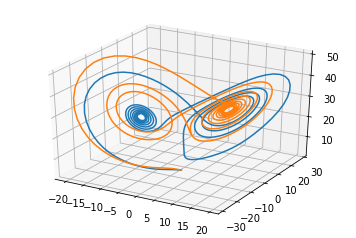

In [58]:
plt.figure()
plt.gca(projection='3d')
plt.plot(x[0],x[1],x[2])
plt.plot(xsol[0],xsol[1],xsol[2])
plt.show()

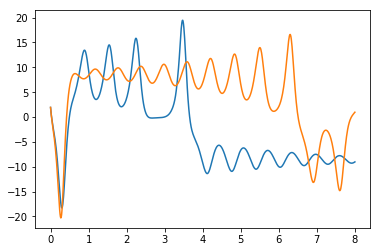

In [ ]:
for i in range(3):
    plt.figure()
    plt.plot(t,x[i])
    plt.plot(t,xsol[i])
    plt.show()


In [ ]:
len(X)

In [ ]:
x[1]


In [ ]:
len(t)